In [1]:
cd ../ 

/Users/swetali/Desktop/Aix-Marseille/MRI-DL-AMU/DDM2


144


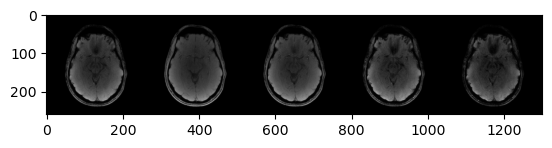

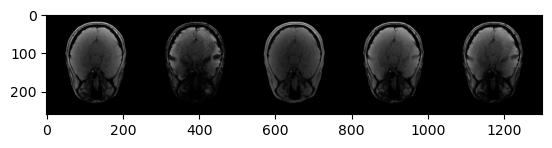

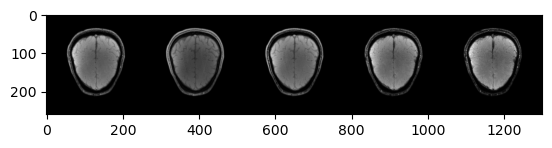

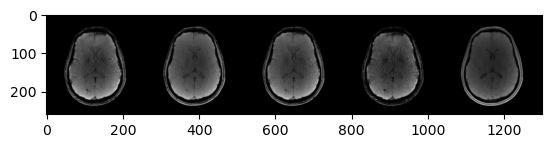

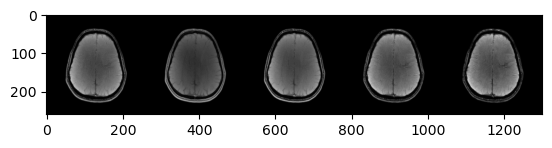

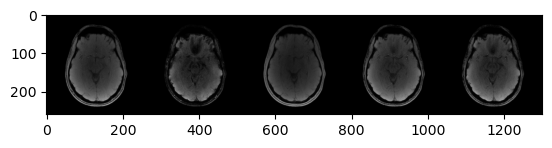

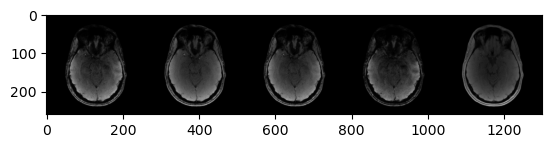

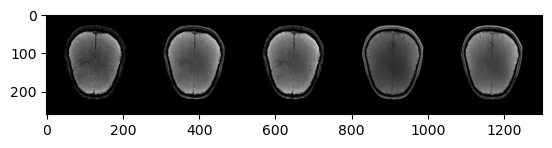

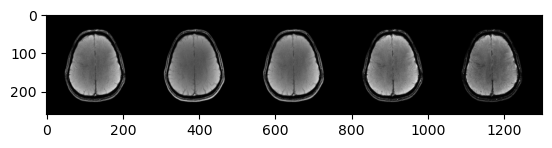

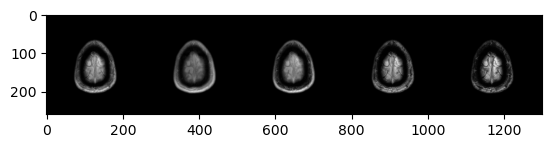

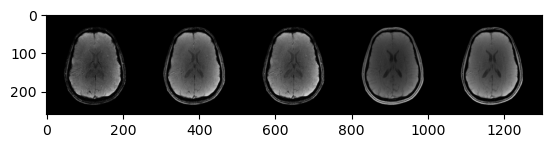

In [2]:
import torch 
from data.mri_dataset import MRIDataset
import numpy as np
import matplotlib.pyplot as plt

dataset = MRIDataset('dataset/test.nii.gz', valid_mask=[0,6],
                         phase='train', val_volume_idx=40, padding=5)#, initial_stage_file='/media/administrator/1305D8BDB8D46DEE/stanford/MRI/experiments/v25_noisemodel/stages.txt')

print(len(dataset))
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

for i, data in enumerate(trainloader):
    if i > 10:
        break
    img = data['X']
    condition = data['condition']
    img = img.numpy()
    condition = condition.numpy()

    target = np.hstack([condition[0,[j]].transpose(1,2,0) for j in range(condition.shape[1])])
    vis = np.hstack((img[0].transpose(1,2,0), target))
    # plt.imshow(img[0].transpose(1,2,0), cmap='gray')
    # plt.show()
    # plt.imshow(condition[0,[0]].transpose(1,2,0), cmap='gray')
    # plt.show()
    # plt.imshow(condition[0,[1]].transpose(1,2,0), cmap='gray')
    # plt.show()

    plt.imshow(vis, cmap='gray')
    plt.show()

In [5]:
import numpy as np
from data.load_data import load_nifty, save_nifty
import matplotlib.pyplot as plt

0.7757285237312317 0.823681


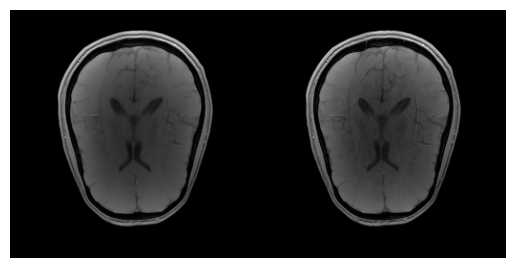

0.7879922986030579 0.73046273


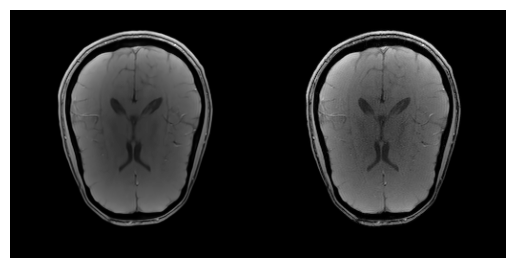

0.6518225073814392 0.6555675


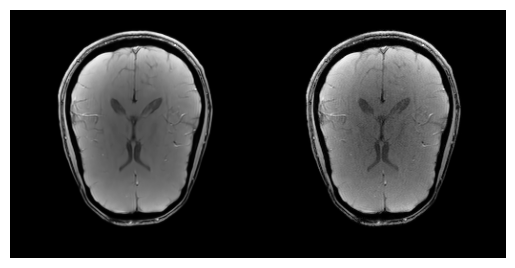

0.6855055093765259 0.6704571


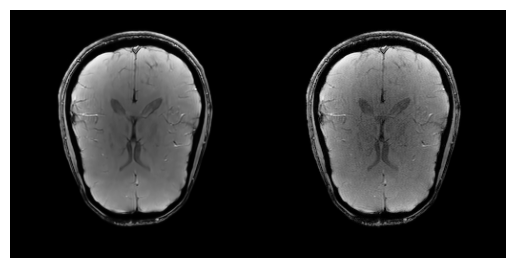

0.6405026316642761 0.69763446


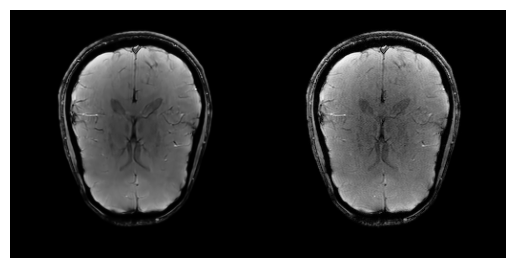

0.6074930429458618 0.6149238


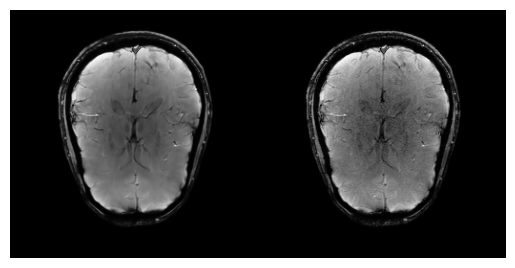

In [19]:
import matplotlib.pyplot as plt
raw_data = load_nifty('/Users/swetali/Desktop/s4gdm/mri_denoised.nii')
crraki_data = np.float32(load_nifty('dataset/test.nii.gz'))
crraki_data = crraki_data.astype(np.float32) / np.max(crraki_data, axis=(0,1,2), keepdims=True)

my_dpi = 200

for i in range(6):
    print(np.max(raw_data[:,:,4:5,i]), np.max(crraki_data[:,:,4:5,i]))
    vis = np.hstack((raw_data[:,:,4:5,i], crraki_data[:,:,4:5,i]))
    plt.axis('off')
    plt.imshow(vis, cmap='Greys_r')
    plt.show()

In [ ]:
#get unsampled data
def get_data(filename, datasetname='dataset', noise=None, interleaved=True):
    
    # Handle the imaging data
    dset = ismrmrd.Dataset(filename, datasetname, create_if_needed=False)
    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    enc = header.encoding[0]

    # Matrix size
    eNx = enc.encodedSpace.matrixSize.x
    eNy = enc.encodedSpace.matrixSize.y
    eNz = enc.encodedSpace.matrixSize.z
    rNx = enc.reconSpace.matrixSize.x
    rNy = enc.reconSpace.matrixSize.y
    rNz = enc.reconSpace.matrixSize.z
    
    # Field of View
    eFOVx = enc.encodedSpace.fieldOfView_mm.x
    eFOVy = enc.encodedSpace.fieldOfView_mm.y
    eFOVz = enc.encodedSpace.fieldOfView_mm.z
    rFOVx = enc.reconSpace.fieldOfView_mm.x
    rFOVy = enc.reconSpace.fieldOfView_mm.y
    rFOVz = enc.reconSpace.fieldOfView_mm.z
    
    # Number of Slices, Reps, Contrasts, etc.
    ncoils = header.acquisitionSystemInformation.receiverChannels
    if enc.encodingLimits.slice != None:
        nslices = enc.encodingLimits.slice.maximum + 1
    else:
        nslices = 1
    
    if enc.encodingLimits.repetition != None:
        nreps = enc.encodingLimits.repetition.maximum + 1
    else:
        nreps = 1
    
    if enc.encodingLimits.contrast != None:
        ncontrasts = enc.encodingLimits.contrast.maximum + 1
    else:
        ncontrasts = 1
    
    # Initialiaze a storage array
    all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, int(eNx/2), eNy, eNz), dtype=np.complex64)
    #all_acs = 
    # TODO loop through the acquisitions looking for noise scans
    firstacq=0
    for acqnum in range(dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)
        # TODO: Currently ignoring noise scans
        if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            #print("Found noise scan at acq ", acqnum)
            continue
        elif acq.isFlagSet(ismrmrd.ACQ_IS_PARALLEL_CALIBRATION):
            #print("Found acs can at acq ", acqnum)
            continue 
        else:
            firstacq = acqnum
            print("Imaging acquisition starts acq ", acqnum)
            break

    refNx = acq.number_of_samples
    x0 = (eNx - refNx)// 2
    x1 = eNx - (eNx - refNx)//2
    print(x0,x1)
   
    # Loop through the rest of the acquisitions and stuff 
    for acqnum in range(firstacq,dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum) 
        #remove oversampling 
        acq_data = acq.data
        eNx2 = acq_data.shape[1]
        print(eNx, acq_data.shape[1])
        if(eNx2-eNx<0):
            acq_data = np.pad(acq_data, ((0,0),(eNx-eNx2,0)), 'constant')

        xline = transform_kspace_to_image(acq_data, [1])
        xline = xline[:,x0:x1]
        acq.resize(int(eNx/2),acq.active_channels,acq.trajectory_dimensions)
        acq.center_sample = int(eNx/4)
        # need to use the [:] notation here to fill the data
        acq.data[:] = transform_image_to_kspace(xline, [1])
        
        # Stuff into the buffer
        rep = acq.idx.repetition
        contrast = acq.idx.contrast
        slice = acq.idx.slice
        y = acq.idx.kspace_encode_step_1
        z = acq.idx.kspace_encode_step_2
        #print(f"rep: {rep} contrast: {contrast} slice: {slice} y: {y} z: {z}, {acq.data.shape}")
        if (acq.data.shape[0] == ncoils):
            all_data[rep, contrast, slice, :, :, y, z] = acq.data
    print(all_data.shape)

    dset.close()
    
    if eNz > 1:
        return all_data
    else:
        return all_data[...,:,:,0]

In [ ]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def perform_t_test(df, R, method1, method2, metrics, alternative, alpha=0.01):
    
    method1_data = df[(df['Method'] == method1) & (df['R'] == R)][metrics].round(2)
    method2_data = df[(df['Method'] == method2) & (df['R'] == R)][metrics].round(2)

    t, p = stats.ttest_ind(method1_data, method2_data, equal_var=False,
                           alternative=alternative)
    
    #print(f"m1 {method1_data.mean():.2f} m2: {method2_data.mean():.2f}")
    result = f"Metrics {metrics}, R: {R}\tMethod 1: {method1}\tMethod 2: {method2}\t t-statistic: {t:.3f}\tp-value: {p:.3f}"
    
    if p <= alpha:
        result += f"\t{method1} is significantly better than {method2}"
    else:
        result += f"\t{method1} is not significantly better than {method2}"
    
    print(result)

In [ ]:
# Read in CSV file
df = pd.read_csv('data/results/crraki/T2-weighted.csv', delimiter=';')
df = df.drop(columns=['index'])

grouped = df.groupby(['R'])
comparisons = [('resrakiComplex2D', 'Grappa2D'),('resrakiComplex2D', 'resraki2D')]
metrics = {'NRMSE_IM': 'less',
            'NMAE_IM': 'less',
            'SSIM':'greater',
            'PSNR':'greater'}
# Perform one-sided Welch's t-test for each pair of groups
p_values = []
for keys in metrics:
    for R in sorted(df['R'].unique()):
        for method1, method2 in comparisons:
            perform_t_test(df, R, method1, method2, keys, metrics[keys])

In [ ]:
# Read in CSV file
df = pd.read_csv('data/results/crraki/2D_MULTIGRE.csv', delimiter=';')
df = df.drop(columns=['index'])

grouped = df.groupby(['R'])
comparisons = [('resrakiComplex2D', 'Grappa2D'),('resrakiComplex2D', 'resraki2D')]
metrics = {'NRMSE': 'less',
            'NMAE': 'less',
            'SSIM':'greater',
            'PSNR':'greater'}
# Perform one-sided Welch's t-test for each pair of groups
p_values = []
for keys in metrics:
    for R in sorted(df['R'].unique()):
        for acs in sorted(df['ACS'].unique()):
            print(F"ACS {acs} ")
            for method1, method2 in comparisons:
                perform_t_test(df[df['ACS']== acs], R, method1, method2, keys, metrics[keys])

In [15]:
def perform_t_test2(df, R, method, method1, method2, metrics, alternative, alpha=0.05):
    
    method1_data = df[(df['ACS'] == method1) & (df['R'] == R) & (df['Method']==method)][metrics].round(2)
    method2_data = df[(df['ACS'] == method2) & (df['R'] == R) & (df['Method']==method)][metrics].round(2)

    t, p = stats.ttest_ind(method1_data, method2_data, equal_var=False,
                           alternative=alternative)
    
    #print(f"m1 {method1_data.mean():.2f} m2: {method2_data.mean():.2f}")
    result = f"Metrics {metrics}, R: {R}\tMethod 1: {method1}\tMethod 2: {method2}\t t-statistic: {t:.3f}\tp-value: {p:.3f}"
    
    if p <= alpha:
        result += f"\t{method1} is significantly better than {method2}"
    else:
        result += f"\t{method1} is not significantly better than {method2}"
    
    print(result)
    return p

In [16]:
comparisons = [(64, 48),(64, 36), (64, 24)]
p = {'NRMSE': [],
        'NMAE': [],
        'SSIM': [],
        'PSNR': []}

for keys in metrics:
    for method in sorted(df['Method'].unique()):
        print(f"method {method}")
        for method1, method2 in comparisons:
            p_value = perform_t_test2(df, 5, method, method1, method2, keys, metrics[keys])
            p[keys].append(p_value)

method Grappa2D
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 48	 t-statistic: 0.607	p-value: 0.728	64 is not significantly better than 48
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 36	 t-statistic: -2.164	p-value: 0.015	64 is significantly better than 36
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 24	 t-statistic: nan	p-value: nan	64 is not significantly better than 24
method resraki2D
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 48	 t-statistic: -0.021	p-value: 0.492	64 is not significantly better than 48
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 36	 t-statistic: -1.441	p-value: 0.075	64 is not significantly better than 36
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 24	 t-statistic: -14.419	p-value: 0.000	64 is significantly better than 24
method resrakiComplex2D
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 48	 t-statistic: 0.573	p-value: 0.716	64 is not significantly better than 48
Metrics NRMSE, R: 5	Method 1: 64	Method 2: 36	 t-statistic: 0.913	p-value: 0.819	64 is not significantly bette

In [ ]:
import pandas as pd
import seaborn as sns

#palette="dark:#58d_r"

df = pd.read_csv(r'data/results/crraki/2D_MULTIGRE.csv', delimiter=';')
sns.set_theme(style="white", font_scale=1.2)

for keys in p:
    g = sns.catplot(data = df[df['R'] == 5], 
                    x = "Method", 
                    y = keys,
                    hue = "ACS",
                    errorbar=None,
                    kind = "bar", 
                    height = 4, 
                    palette = "dark:salmon_r")
    g.set_axis_labels("", keys)
    g.set_xticklabels(["GRAPPA", "rRAKI","crRAKI"])
    g.set_titles("ACS = ")
    #g.set(ylim=(20, 45))
    plt.show()

In [ ]:
import pandas as pd
import seaborn as sns

#palette="dark:#58d_r"

df = pd.read_csv(r'data/results/crraki/2D_MULTIGRE.csv', delimiter=';')
sns.set_theme(style="white", font_scale=1.2)

df['Method'] = df['Method'].replace({'Grappa2D' : 'GRAPPA', 'resraki2D': 'rRAKI', 'resrakiComplex2D': 'crRAKI'})
for keys in p:
    g = sns.catplot(data = df, 
                    x = "R", 
                    y = keys,
                    hue = "Method",
                    col='ACS',
                    errorbar=None,
                    kind = "bar", 
                    height = 4, 
                    palette = "dark:#58d_r")
    g.set_axis_labels("", keys)
    g.set_xticklabels(["R=4", "R=5","R=6"])
    #g.set_titles(f"ACS = {col.value}")
    #g.set(ylim=(20, 45))
    plt.show()

In [ ]:
my_dpi = 200
im = load_nifty('experiments/mriRAKIGAN/g_iters-10/lr_d-1e-4/lr_g-0.1/alpha-0.1/out/volunteer1_norm/acc_6_slice_14_contrast_0.nii')
error_map = np.abs(normalize(ref[0]) - normalize(im[0]))
plt.axis('off')        
plt.imshow(error_map, cmap='Greys_r')
plt.savefig(f'./data/results/raki_with_d_error_maps_6.png', dpi=my_dpi)
plt.show()


In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

In [ ]:
import pandas as pd

plotdata = pd.DataFrame({

    "GRAPPA":[0.946,0.902, 0.844, 0.732],

    "resRAKI":[0.955, 0.920, 0.915, 0.876],

    "crRAKI": [0.898, 0.901, 0.867, 0.854]
    },

    index=["W/o Discriminator (R=5)", "W/ Discriminator (R=5)", "W/o Discriminator (R=6)", "W/ Discriminator (R=6)",])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.ylabel('SSIM', fontsize=24)
plt.xticks(fontsize=16, rotation=360)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc=4)

In [ ]:
import glob,re

my_dpi = 200
dir = ['experiments/mriRakiComplexGAN_loss_balance_more_alpha/g_iters-10/lr_d-1e-2/lr_g-1e-2/alpha-*/out/volunteer1_norm/*acc_5*slice_14_contrast_0.nii' ]
fig = plt.figure(figsize=(10, 10), dpi=my_dpi)
print(fig)
c=1

for i,filename in enumerate(dir):
    for file in sorted(glob.glob(filename)):
        labels=re.search('experiments.*alpha-(.*)/out/.*',file)
        im = load_nifty(file)
        
        #ax = fig.add_subplot(9,6,c)
        #ax.set_aspect('equal')
        #ax.set_title(f'ALPHA = {labels.group(1)}',fontsize=8)
        plt.imshow(np.flipud(im[0,...]), cmap='Greys_r')
        plt.axis('off')
        #c+=1
        #plt.tight_layout()
        plt.savefig(f'./data/results/craki_with_alpha/{labels.group(1)}.png', dpi=my_dpi)
        plt.show()

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
dataset_head1 = TensorDataset(torch.randn(10, 1), torch.randn(10, 1))
dataset_head2 = TensorDataset(torch.randn(10, 1), torch.randn(10, 1))

for epoch in range(2):
    print('epoch ', epoch)
    # in epoch loop
    loader1 = DataLoader(dataset_head1)
    iter_loader1 = iter(loader1)
    loader2 = DataLoader(dataset_head2)
    iter_loader2 = iter(loader2)
    
    try:
        while True:
            # train head1
            data, target = next(iter_loader1)
            print('training head1')
    
            # train head2
            data, target = next(iter_loader2)
            print('training head2')
    except StopIteration:
        pass


In [ ]:
import torch

def get_number_of_parameters(dict):
    tensor_dict = torch.load(dict, map_location='cpu') # OrderedDict
    tensor_list = list(tensor_dict.items())
    total = 0
    for layer_tensor_name, tensor in tensor_list:
        print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
        total += torch.numel(tensor)
    print(f'Total number of weights and biases: {total}')

In [ ]:
x = np.linspace(0, 10, 100)
y = 1/np.exp(-x)
y_2 = 1/np.exp(-(x**2))

plt.figure()
plt.plot(x, y)
plt.xlabel('$x$')
plt.ylabel('$\ y$')

plt.figure()
plt.plot(x, y_2)
plt.xlabel('$x$')
plt.ylabel('$\ y$')

y_prime = np.power(x,4)/(np.power(x,4) + np.power(7,4))
plt.figure()
plt.xlabel('$x$')
plt.ylabel('$\ y$')
plt.plot(x, y_prime)

plt.show()

In [ ]:
import glob
filename = 'mask.npy'
k=np.load('./data/vida/volunteer1/meas_MID00067_FID00146_T2_DP_TSE_TRA_p2_64ch_ACS40_sep_2_acs.npy')
k_slice = k[12,45]
for file in glob.glob(filename):
    mask_1 = np.load(file)
    mask = mask_1[0,45,mask_1.shape[2]//2-32:mask_1.shape[2]//2+32,mask_1.shape[3]//2-20:mask_1.shape[3]//2+20]
    print(file)
    masked_image = np.multiply(k_slice, mask)
    #sos = np.sqrt(np.sum(np.multiply(np.abs(image),np.abs(image)),axis=(1)))
    plt.imshow(np.abs(masked_image/np.max(masked_image)), cmap='Greys_r', clim=(1e-8, 1e-1))
    plt.axis('off')
    plt.savefig(f'{file}.png', dpi=my_dpi)
    plt.show()

In [ ]:

filename = 'mask.npy'
mask = np.load(filename)
print(mask.shape)
my_dpi = 200

plt.figure(figsize = (16, 8))
plt.imshow(mask[0,45], cmap='Greys_r', clim=(1e-7, 8e-4))
plt.axis('off')
plt.show()

In [ ]:
def myFun(*args,**kwargs):
    my_kwargs=kwargs
    print("args: ", args)
    print("kwargs: ", my_kwargs)


# Now we can use both *args ,**kwargs
# to pass arguments to this function :
myFun('geeks','for','geeks',first="Geeks",mid="for",last="Geeks")


In [ ]:
import torch

raw = torch.zeros((4*4,))
raw[:int(0.3 * 4 * 4)] = 1.  # set EXACTLY 30% of the pixels in the mask
ridx = torch.randperm(4*4)   # a random permutation of the entries
mask = torch.reshape(raw[ridx], (4, 4))
print(mask)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Input x, output y
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Creates figure first
my_dpi = 40
fig = plt.figure(figsize=(20, 10), dpi=my_dpi)
print(fig)

fig.suptitle('Subplot example3-1: Add subplot later', fontsize=20)

# Add plots
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x, y)
ax1.set_xlabel('X label, plot1')
ax1.set_ylabel('Y label, plot1')
ax1.set_xticklabels('')
ax1.set_yticklabels('')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(x, y)
ax2.set_xlabel('X label, plot2')
ax2.set_ylabel('Y label, plot2')

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xlabel('X label, plot3')
ax3.set_ylabel('Y label, plot3')

fig.savefig('Subplot_ex3.png')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from graphs.models.custom_layers.complex_layers import complexConv2d, complexReLU
from torch.nn import Module, ReLU, Conv2d

class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = complexConv2d(in_channels=4, out_channels=4, kernel_size=(1,1))
        self.conv2 = complexConv2d(in_channels=4, out_channels=2, kernel_size=(1,1))
        self.conv3 = complexConv2d(in_channels=2, out_channels=4, kernel_size=(1,1))
             
    def forward(self,x):
        (x_real,x_img) = x[...,0],x[...,1]
        (x_real,x_img) = self.conv1(x_real,x_img)
        (x_real,x_img) = self.conv2(x_real,x_img)
        (x_real,x_img) = self.conv3(x_real,x_img)
        (x_real,x_img) =(torch.unsqueeze(x_real, 4), torch.unsqueeze(x_img, 4))
        out = torch.cat((x_real,x_img),-1)

        return out


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2d(in_channels=8, out_channels=4, kernel_size=(1,1), bias=False)
        self.conv2 = Conv2d(in_channels=4, out_channels=2, kernel_size=(1,1), bias=False)
        self.conv3 = Conv2d(in_channels=2, out_channels=8, kernel_size=(1,1),bias=False)
             
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        out = self.conv3(x)

        return out

def count_parameters_by_model(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        print(f'Layer: {name} {param} elements')
        total_params+=param
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def get_number_of_parameters_by_dict(dict):
    tensor_dict = torch.load(dict, map_location='cpu') # OrderedDict
    tensor_list = list(tensor_dict.items())
    total = 0
    for layer_tensor_name, tensor in tensor_list:
        print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
        total += torch.numel(tensor)
    print(f'Total number of weights and biases: {total}')

In [ ]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_complex = ComplexNet().to(device)
model_naive = Net().to(device)
count_parameters_by_model(model_complex)
count_parameters_by_model(model_naive)


#naive implementation concatanate real & img on coil channel
input_size_concat = (1,8,10,10)
input_concat = torch.rand((input_size_concat))
naive = model_naive.forward(input_concat)
print(naive.shape)

#complex implementation concatante real & img on the last dimension
input_size_complex = (1,4,10,10,2)
input_complex = torch.rand((input_size_complex))
complex = model_complex.forward(input_complex)
print(complex.shape)


In [ ]:
import torch
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4

# Construct G-Conv layers
C1 = P4ConvZ2(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
C2 = P4ConvP4(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

# Create 10 images with 3 channels and 9x9 pixels:
x = Variable(torch.randn(10, 3, 9, 9))

# fprop
y = C1(x)
print (y.data.shape)  # (10, 64, 4, 9, 9)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

mse_csv = 'experiments/Grappa/out/volunteer1_raki_factor/rss_acc_5_kernel_5_4_cutofffreq_60_noise_level_100_exppower_1.volunteer1_raki_factor.csv'
mse_weighted_csv = 'experiments/Grappa/out/volunteer1_weighted_auto/rss_acc_5_kernel_5_4_cutofffreq_60_noise_level_100_exppower_1.volunteer1_weighted_auto.csv'

df_mse = pd.read_csv(mse_csv, delimiter='\t')
df_weighted = pd.read_csv(mse_weighted_csv, delimiter='\t')

df_mse.head()

# Two-sample T-test

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same. Unlike the one sample-test where we test against a known population parameter, the two sample test only involves sample means. You can conduct a two-sample t-test by passing with the stats.ttest_ind() function. Let's generate a sample of voter age data for Wisconsin and test it against the sample we made earlier:

# Paired T-test
The basic two sample t-test is designed for testing differences between independent groups. In some cases, you might be interested in testing differences between samples of the same group at different points in time. For instance, a hospital might want to test whether a weight-loss drug works by checking the weights of the same group patients before and after treatment. A paired t-test lets you check whether the means of samples from the same group differ. 


In [ ]:
mse = df_mse['Normalized_Weighted_RMSE']
weighted_mse = df_weighted['Normalized_Weighted_RMSE']

#Two-Sample T-Test
print(f'Two-sample T-test {stats.ttest_ind(a= mse,\
                b= weighted_mse,equal_var=False)}' )   # Assume samples have equal variance?

#paired t-test
print(f'Paired T-test {stats.ttest_rel(a = mse,\
                b = weighted_mse)}')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import gc 

pd.set_option('display.float_format', lambda x: '%0.4f' % x)
header=['algo', 'alpha', 'data', 'acceleration','contrast' , 'a0', 'a1', 'a2', 'a3','a4', 'a5', 'a6','a7', 'a8','a9', 'RMSE', 'MAE', 'SSIM', 'PSNR']
df = pd.read_csv('../experiments/plots/results_alpha.csv', sep='\t', names=header, index_col=False)
df = df.drop(columns=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6','a7', 'a8','a9'])
df['alpha'] = df['alpha'].str.replace(r'alpha-', '')
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize':20,
          'ytick.labelsize': 20}
plt.rcParams.update(params)

count=0
for algo in df.algo.unique():
    for acc in df.acceleration.unique():
        for contrast in df.contrast.unique():
            for data in df.data.unique():
                df_1 = df.loc[(df.algo==algo) & (df.acceleration==acc) & (df.contrast==contrast) & (df.data==data)]
                if not df_1.empty:
                    # plot
                    # Create figure
                    x = df_1['alpha']
                    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20), dpi=40)
                    fig.suptitle(f'Method:{algo}@acceleration:{acc}\ncontrast:{contrast}\ndata:{data}\n', fontsize=20)
                    ax1.plot(x, df_1['RMSE'])
                    ax1.set(xlabel='alpha', ylabel='RMSE')
                    ax2.plot(x, df_1['MAE'])
                    ax2.set(xlabel='alpha', ylabel='MAE')
                    ax3.plot(x, df_1['SSIM'])
                    ax3.set(xlabel='alpha', ylabel='SSIM')
                    ax4.plot(x, df_1['PSNR'])
                    ax4.set(xlabel='alpha', ylabel='PSNR')
                    plt.tight_layout()
                    fig.savefig(f'../experiments/plots/data_{data}_Method_{algo}_acceleration_{acc}_contrast_{contrast}.png', bbox_inches='tight')

In [ ]:
import glob
from utils.load_data import load_nifty
import matplotlib.animation as animation
import matplotlib.pyplot as plt

img_list=[]

dir='experiments/Spirit/out/volunteer1_norm/results/*acc_4*contrast_0*nii'

for file in glob.glob(dir):
    img_list=load_nifty(file)
    fig = plt.figure(figsize=(6,6))
    plt.axis("off") 
    ims = [[plt.imshow(img_list[i], animated=True, cmap='Greys_r')] for i in range(img_list.shape[0])]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    writervideo = animation.FFMpegWriter(fps=2)
    ani.save(f'{file}.mp4', writer=writervideo)

In [ ]:
#code for patch log likely hood

import torch
import torch.nn as nn
from torch.optim import Adam

class EPLL(nn.Module):
    def __init__(self, patches, means, covs):
        super(EPLL, self).__init__()
        self.patches = torch.Tensor(patches)
        self.means = torch.Tensor(means)
        self.covs = torch.Tensor(covs)

    def forward(self, x):
        # Compute the EPLL score for the input image
        patch_scores = []
        for i in range(self.patches.shape[0]):
            patch = self.patches[i]
            mean = self.means[i]
            cov = self.covs[i]
            patch_scores.append(-0.5 * torch.logdet(cov) - 0.5 * torch.matmul((patch - mean).view(1,-1), torch.inverse(cov)) @ (patch - mean).view(-1,1))
        return torch.mean(torch.stack(patch_scores))

def solve_inverse_problem(y, H, patches, means, covs, lambda_, num_iterations=1000, lr=0.01):
    """
    Solve the inverse problem using the EPLL prior.
    """
    x = nn.Parameter(torch.randn(H.shape[1]))  # Initial guess for the solution
    epll = EPLL(patches, means, covs)
    optimizer = Adam([x], lr=lr)
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = 0.5 * torch.norm(y - H @ x) ** 2 + lambda_ * epll(x)
        loss.backward()
        optimizer.step()
    return x



In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam

class EPLL(nn.Module):
    def __init__(self, patches, means, covs):
        super(EPLL, self).__init__()
        self.patches = torch.Tensor(patches)
        self.means = torch.Tensor(means)
        self.covs = torch.Tensor(covs)

    def forward(self, x):
        # Compute the EPLL score for the input image
        patch_scores = []
        for i in range(self.patches.shape[0]):
            patch = self.patches[i]
            mean = self.means[i]
            cov = self.covs[i]
            patch_scores.append(-0.5 * torch.logdet(cov) - 0.5 * torch.matmul((patch - mean).view(1,-1), torch.inverse(cov)) @ (patch - mean).view(-1,1))
        return torch.mean(torch.stack(patch_scores))

def solve_inverse_problem(y, H, patches, means, covs, lambda_epll, lambda_adv, num_iterations=1000, lr=0.01):
    """
    Solve the inverse problem using the EPLL prior and adversarial loss.
    """
    x = nn.Parameter(torch.randn(H.shape[1]))  # Initial guess for the solution
    epll = EPLL(patches, means, covs)
    discriminator = Discriminator()
    optimizer = Adam([x], lr=lr)
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = 0.5 * torch.norm(y - H @ x) ** 2 + lambda_epll * epll(x) + lambda_adv * discriminator(x)
        loss.backward()
        optimizer.step()
    return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(128*128, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, 128*128)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def solve_inverse_problem(y, H, patches, means, covs, lambda_epll, lambda_adv, num_iterations=1000, lr=0.01):
    """
    Solve the inverse problem using the EPLL prior and adversarial loss.
    """
    x = nn.Parameter(torch.randn(H.shape[1]))  # Initial guess for the solution
    epll = EPLL(patches, means, covs)
    discriminator = Discriminator()
    optimizer = Adam([x], lr=lr)
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = 0.5 * torch.norm(y - H @ x) ** 2 + lambda_epll * epll(x) + lambda_adv * (1 - discriminator(x)) # Minimizing the adversarial loss
        loss.backward()
        optimizer.step()
    return x


In [ ]:
import numpy as np
import torch
from sklearn.model_selection import KFold

# Define the model architecture and optimization method
model = ...
criterion = ...
optimizer = ...

# Define the hyperparameters to be searched
param_grid = {'kernel1': ['[5,4]', '[5,2]'],
              'hidden_layer_1': [8, 16, 32]}

# Define the number of folds for cross validation
k = 5

# Split the data into k folds
kf = KFold(n_splits=k)

best_model = None
best_mse = float('inf')

# Iterate over all hyperparameter combinations
for k1 in param_grid['kernel1']:
    for hl1 in param_grid['hidden_layer_1']:
        fold_mse = []
        # Split the data into train and validation sets for each fold
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Convert the data to PyTorch tensors and move them to the GPU (if available)
            X_train, y_train = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device)
            X_val, y_val = torch.Tensor(X_val).to(device), torch.Tensor(y_val).to(device)

            # Train the model on the train data for each fold
            model.train()
            for inputs, labels in zip(X_train, y_train):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model on the validation data for each fold
            model.eval()
            with torch.no_grad():
                mse = criterion(model(X_val), y_val)
                fold_mse.append(mse.item())

        # Calculate the mean MSE across all folds
        mean_mse = np.mean(fold_mse)

        # Update the best model if the mean MSE is lower than the previous best
        if mean_mse < best_mse:
            best_mse = mean_mse
            best_model = model

# The best model with the best hyperparameters is stored in the `best_model` variable
